<div align="center"><h1> <font color='cyan'>Assignment 2 - Building Neural Networks and CNNs</font>

<h3>Checkpoint: October 24, Thu, 11:59pm</h3>
<h2><font color='red'>Due Date: November 7, Thu, 11:59pm</h2></font> 
</div>


Welcome to our second assignment. This assignment focuses on building fully connected neural networks (NN) and convolutional neural networks (CNN).<br/>
In the third part, we will implement a basic CNN and apply optimization and in part 4 we will implement the VGG-11 model. There is also a bonus task focusing on implementing more complex architecture.

<h2><font color='green'>Part III: Building a CNN [30 points]</font></h2>

In this part we will work on a dataset containing multiple classes.

<h2>CNN Dataset:</h2>
    For this part our dataset consists of 36 categories and 2800 examples for each category, thus in total 100,800 samples. Each example is a 28x28 image. A version of the dataset for this assignment can be downloaded from UBlearns (cnn_dataset.zip). Note: The images in the CNN dataset may have either 1 or 3 channels. If an image has 1 channel (grayscale), you can still work with it without any issues.
<h2 style="
    font-family: 'Helvetica Neue', sans-serif;
    color: #2c3e50;
    background: linear-gradient(to right, #3498db, #8e44ad);
    -webkit-background-clip: text;
    color: transparent;
    font-weight: 700;
    letter-spacing: 1px;
    text-transform: uppercase;
    text-shadow: 2px 4px 6px rgba(0, 0, 0, 0.1);
    padding-bottom: 10px;
    border-bottom: 2px solid #3498db;
">Step 1: Load, preprocess, analyze, visualize the dataset and make it ready for training. You can reuse your code from Part I.</h2>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torchvision import datasets, transforms
from torchinfo import summary
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset = datasets.ImageFolder('cnn_dataset', transform=transform)

In [5]:
train_dataset = datasets.ImageFolder('cnn_dataset', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [6]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Total samples: 100800
Training samples: 70560
Validation samples: 15120
Test samples: 15120


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

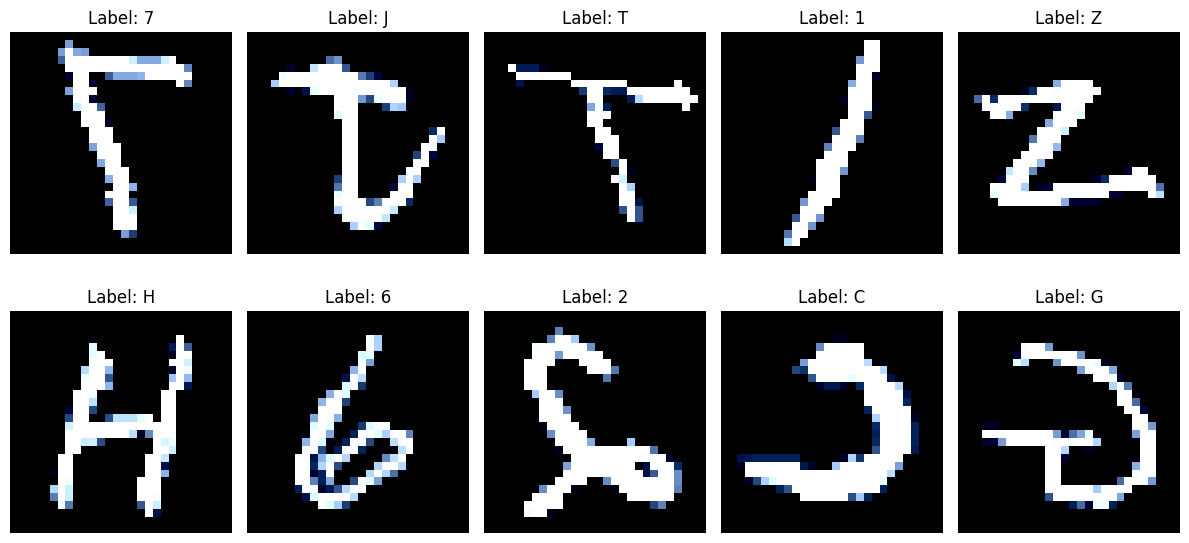

In [8]:
def showImages(loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title(f'Label: {dataset.classes[labels[i]]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

showImages(train_dataloader)

In [9]:
def extract_features(dataset):
    data = []
    labels = []
    for img, label in dataset:
        img_np = img.numpy()
        features = {
            'mean': np.mean(img_np),
            'std': np.std(img_np),
            'label': dataset.classes[label]
        }
        data.append(features)
        labels.append(label)
    return pd.DataFrame(data), np.array(labels)

In [10]:
df, labels = extract_features(dataset)

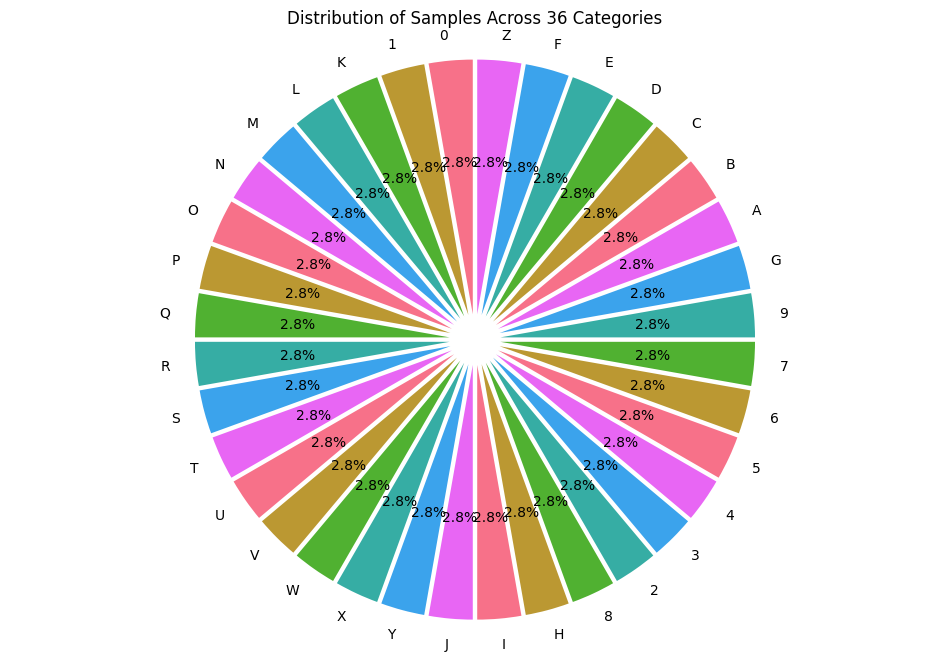

In [11]:
category_counts = df['label'].value_counts()
total_samples = len(df)
category_percentages = (category_counts / total_samples) * 100

plt.figure(figsize=(12, 8))
plt.pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("husl"), explode=[0.1] * len(category_percentages))
plt.title("Distribution of Samples Across 36 Categories")
plt.axis('equal')
plt.show()

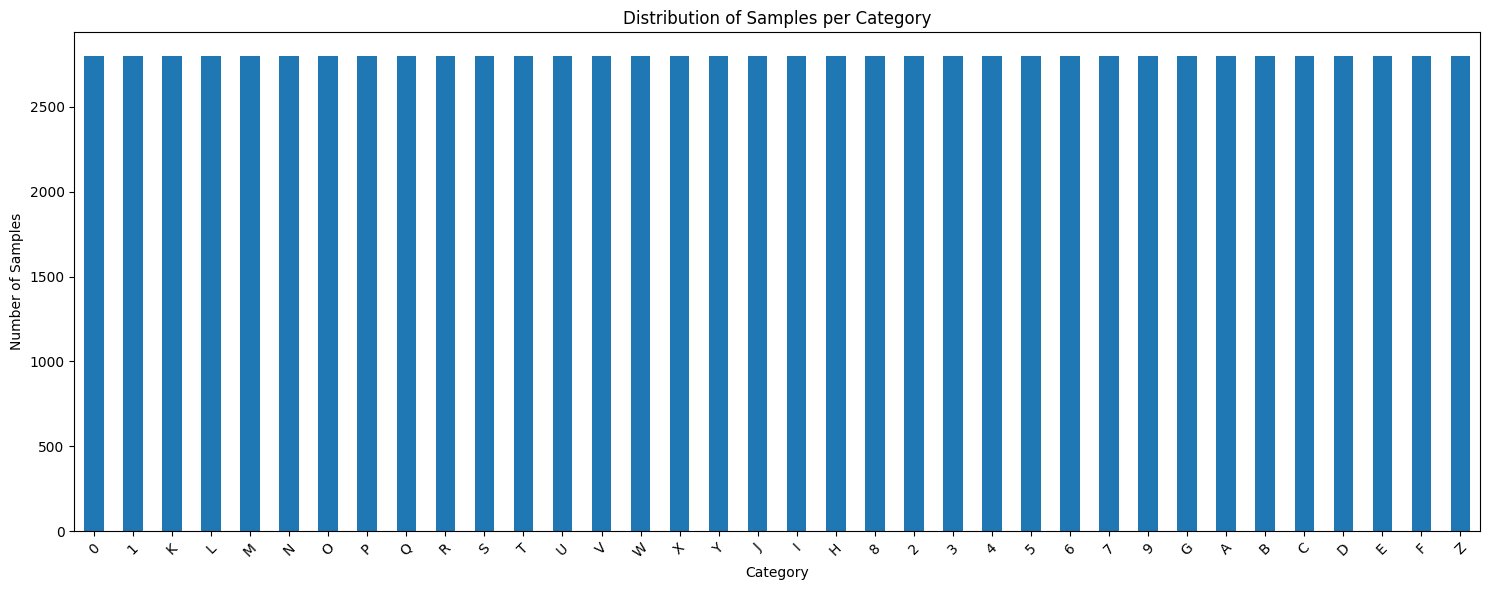

In [12]:
plt.figure(figsize=(15, 6))
df['label'].value_counts().plot(kind='bar')
plt.title("Distribution of Samples per Category")
plt.xlabel("Category")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

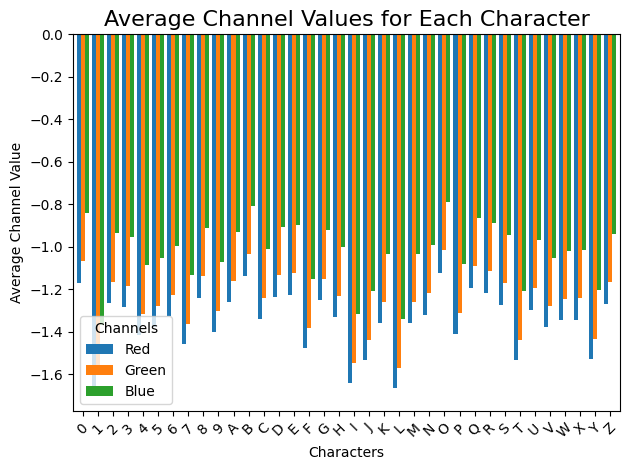

In [13]:
# Correlation Matrix
def get_avg_channel_values(dataset):
    char_data = {char: [] for char in dataset.classes}
    
    for img, label in dataset:
        char = dataset.classes[label]
        char_data[char].append(img.numpy().mean(axis=(1, 2)))
    
    return {char: np.mean(values, axis=0) for char, values in char_data.items()}

avg_channel_values = get_avg_channel_values(dataset)
df = pd.DataFrame.from_dict(avg_channel_values, orient='index', columns=['Red', 'Green', 'Blue'])

plt.figure(figsize=(15, 10))
df.plot(kind='bar', width=0.8)
plt.title('Average Channel Values for Each Character', fontsize=16)
plt.xlabel('Characters')
plt.ylabel('Average Channel Value')
plt.legend(title='Channels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h2 style="
    font-family: 'Helvetica Neue', sans-serif;
    color: #2c3e50;
    background: linear-gradient(to right, #3498db, #8e44ad);
    -webkit-background-clip: text;
    color: transparent;
    font-weight: 700;
    letter-spacing: 1px;
    text-transform: uppercase;
    text-shadow: 2px 4px 6px rgba(0, 0, 0, 0.1);
    padding-bottom: 10px;
    border-bottom: 2px solid #3498db;
">Step 2: Build and train a basic CNN (with max 10 hidden layers). Decide your CNN architecture:</h2>
<ul>
    <li><strong>Input neurons:</strong> 3 (RGB channels)</li>
    <li><strong>Output neurons:</strong> 36</li>
    <li><strong>Hidden layer activation:</strong> ReLU</li>
    <li><strong>Output layer activation:</strong> None (raw logits)</li>
    <li><strong>Number of hidden layers:</strong> 5</li>
    <li><strong>Hidden layer sizes:</strong> 32, 64, 128, 512</li>
    <li><strong>Dropout:</strong> Yes (0.5)</li>
</ul>

<h2 style="
    font-family: 'Helvetica Neue', sans-serif;
    color: #2c3e50;
    background: linear-gradient(to right, #3498db, #8e44ad);
    -webkit-background-clip: text;
    color: transparent;
    font-weight: 700;
    letter-spacing: 1px;
    text-transform: uppercase;
    text-shadow: 2px 4px 6px rgba(0, 0, 0, 0.1);
    padding-bottom: 10px;
    border-bottom: 2px solid #3498db;
">Step 3: Define your CNN architecture using PyTorch</h2>

In [14]:
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 36)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = BaseCNN().to(device)
print(model)

BaseCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=36, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


<h2 style="
    font-family: 'Helvetica Neue', sans-serif;
    color: #2c3e50;
    background: linear-gradient(to right, #3498db, #8e44ad);
    -webkit-background-clip: text;
    color: transparent;
    font-weight: 700;
    letter-spacing: 1px;
    text-transform: uppercase;
    text-shadow: 2px 4px 6px rgba(0, 0, 0, 0.1);
    padding-bottom: 10px;
    border-bottom: 2px solid #3498db;
">Step 4: Return the summary of your model.</h2>

In [15]:
summary(model, input_size=(1, 3, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BaseCNN                                  [1, 36]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           896
├─MaxPool2d: 1-2                         [1, 32, 14, 14]           --
├─Conv2d: 1-3                            [1, 64, 14, 14]           18,496
├─MaxPool2d: 1-4                         [1, 64, 7, 7]             --
├─Conv2d: 1-5                            [1, 128, 7, 7]            73,856
├─MaxPool2d: 1-6                         [1, 128, 3, 3]            --
├─Linear: 1-7                            [1, 512]                  590,336
├─Dropout: 1-8                           [1, 512]                  --
├─Linear: 1-9                            [1, 36]                   18,468
Total params: 702,052
Trainable params: 702,052
Non-trainable params: 0
Total mult-adds (M): 8.56
Input size (MB): 0.01
Forward/backward pass size (MB): 0.36
Params size (MB): 2.81
Estimated Total Size (MB):

<h2 style="
    font-family: 'Helvetica Neue', sans-serif;
    color: #2c3e50;
    background: linear-gradient(to right, #3498db, #8e44ad);
    -webkit-background-clip: text;
    color: transparent;
    font-weight: 700;
    letter-spacing: 1px;
    text-transform: uppercase;
    text-shadow: 2px 4px 6px rgba(0, 0, 0, 0.1);
    padding-bottom: 10px;
    border-bottom: 2px solid #3498db;
">Step 5: Train your model. You can refer to the code from your Part I implementation.</h2>

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_acc = 0.0
    training_losses = []
    validation_losses = []

    training_accuracies = []
    validation_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_loss = train_loss / len(train_loader.dataset)
        training_losses.append(train_loss)
        train_acc = train_correct / train_total
        training_accuracies.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        validation_losses.append(val_loss)
        val_acc = val_correct / val_total
        validation_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
    
    model.load_state_dict(best_model_state)
    return model, best_val_acc, training_losses, training_accuracies, validation_losses, validation_accuracies

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

startTime = time.time()
trained_model, best_val_acc, training_losses, training_accuracies, validation_losses, validation_accuracies = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)
endTime = time.time()
trainingTime = endTime - startTime

Epoch [1/10], Train Loss: 0.9573, Train Acc: 0.6935, Val Loss: 0.4604, Val Acc: 0.8349
Epoch [2/10], Train Loss: 0.5268, Train Acc: 0.8185, Val Loss: 0.3937, Val Acc: 0.8565
Epoch [3/10], Train Loss: 0.4616, Train Acc: 0.8379, Val Loss: 0.3667, Val Acc: 0.8674
Epoch [4/10], Train Loss: 0.4267, Train Acc: 0.8519, Val Loss: 0.3549, Val Acc: 0.8724
Epoch [5/10], Train Loss: 0.4059, Train Acc: 0.8550, Val Loss: 0.3317, Val Acc: 0.8768
Epoch [6/10], Train Loss: 0.3872, Train Acc: 0.8623, Val Loss: 0.3402, Val Acc: 0.8774
Epoch [7/10], Train Loss: 0.3772, Train Acc: 0.8652, Val Loss: 0.3261, Val Acc: 0.8792
Epoch [8/10], Train Loss: 0.3604, Train Acc: 0.8704, Val Loss: 0.3142, Val Acc: 0.8822
Epoch [9/10], Train Loss: 0.3567, Train Acc: 0.8707, Val Loss: 0.3366, Val Acc: 0.8792
Epoch [10/10], Train Loss: 0.3452, Train Acc: 0.8744, Val Loss: 0.3120, Val Acc: 0.8839


In [18]:
trained_model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = trained_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f"\nTraining completed in {trainingTime:.2f} seconds.")
print("------------------------------BASE MODEL------------------------------")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Final Metrics on Validation Set:")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Training completed in 1060.49 seconds.
------------------------------BASE MODEL------------------------------
Best Validation Accuracy: 0.8839
Final Metrics on Validation Set:
Test Accuracy: 0.8819
Test Precision: 0.8829
Test Recall: 0.8819
Test F1 Score: 0.8819


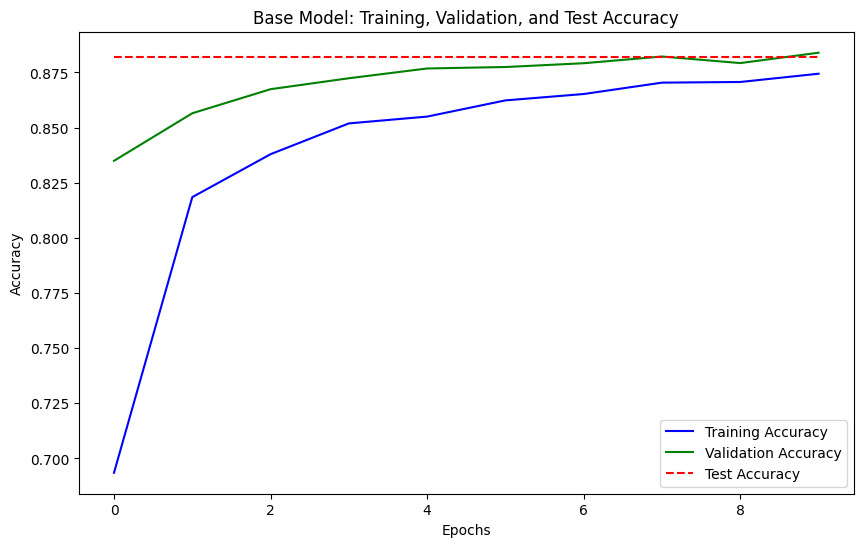

In [19]:
test_accuracy_repeated = [accuracy] * num_epochs

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), training_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(num_epochs), validation_accuracies, label='Validation Accuracy', color='green')
plt.plot(range(num_epochs), test_accuracy_repeated, label='Test Accuracy', color='red', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Base Model: Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

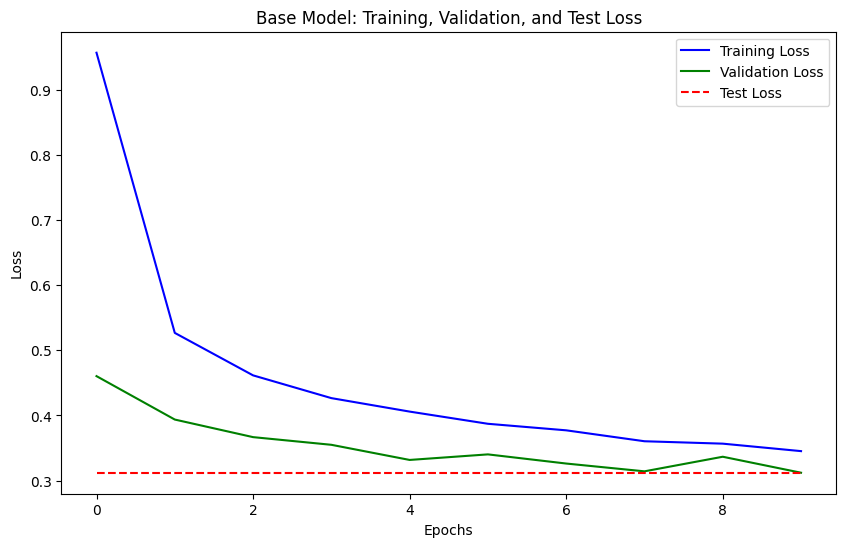

In [20]:
test_loss = validation_losses[-1]
test_loss_repeated = [test_loss] * num_epochs

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), training_losses, label='Training Loss', color='blue')
plt.plot(range(num_epochs), validation_losses, label='Validation Loss', color='green')
plt.plot(range(num_epochs), test_loss_repeated, label='Test Loss', color='red', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Base Model: Training, Validation, and Test Loss')
plt.legend()
plt.show()

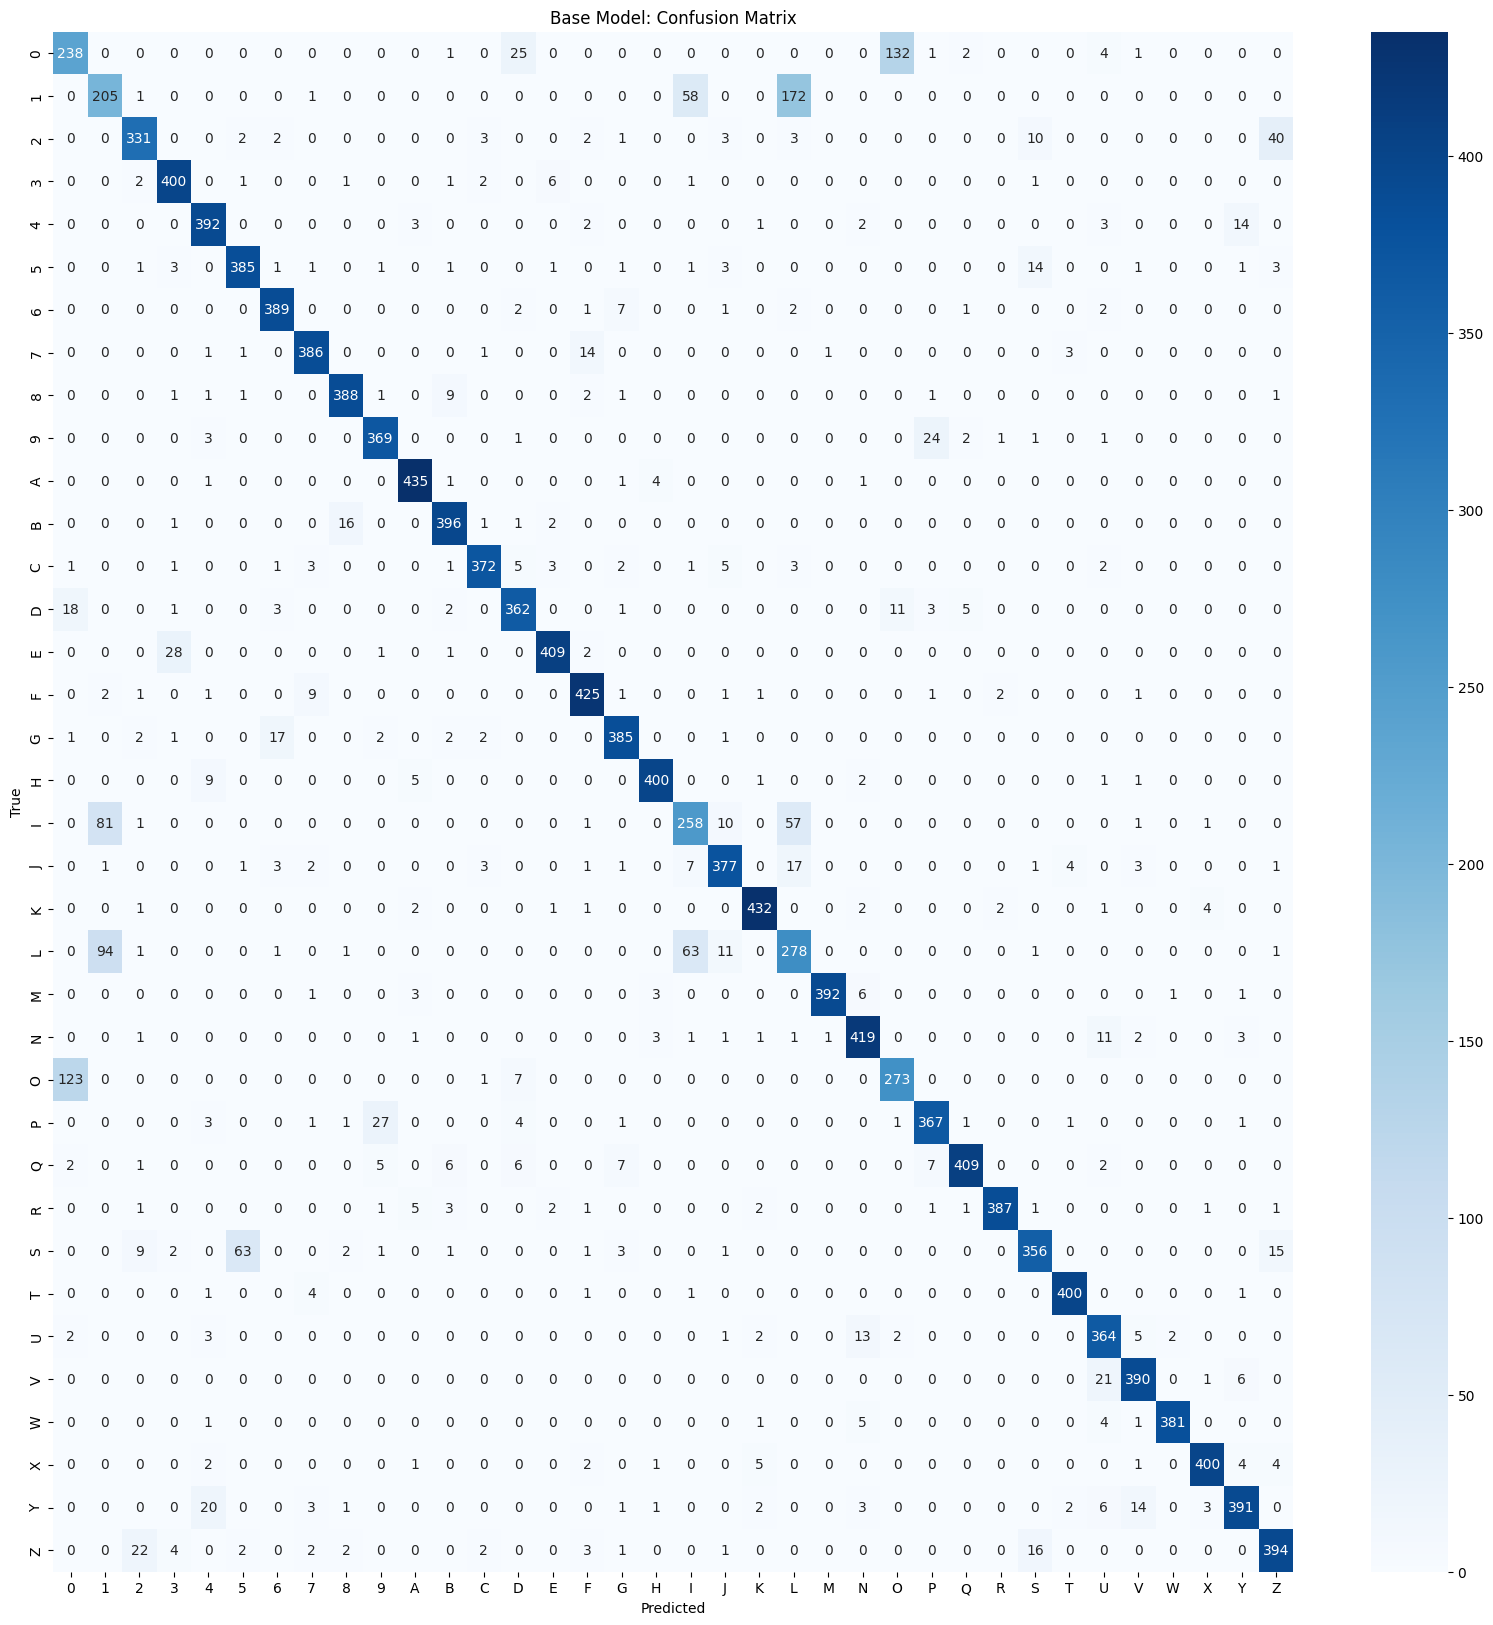

In [21]:
conf_matrix = confusion_matrix(all_labels, all_preds)

class_names = dataset.classes

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Base Model: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<h2 style="
    font-family: 'Helvetica Neue', sans-serif;
    color: #2c3e50;
    background: linear-gradient(to right, #3498db, #8e44ad);
    -webkit-background-clip: text;
    color: transparent;
    font-weight: 700;
    letter-spacing: 1px;
    text-transform: uppercase;
    text-shadow: 2px 4px 6px rgba(0, 0, 0, 0.1);
    padding-bottom: 10px;
    border-bottom: 2px solid #3498db;
">Step 6: Add at least three improvement methods that you tried for “Part II - Step 4” of this assignment, that are applicable to CNN architecture.</h2>

<h3>Batch Normalization Method to optimize CNN</h3>

In [22]:
class BNModel(BaseCNN):
    def __init__(self):
        super(BNModel, self).__init__()
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm1d(512)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = BNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

startTime = time.time()
BatchNormModel, best_val_acc, training_losses, training_accuracies, validation_losses, validation_accuracies = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)
endTime = time.time()
trainingTime = endTime - startTime

BatchNormModel.eval()
all_preds = []
all_labels = []
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = BatchNormModel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

BNAccuracy = correct / total
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f"\nTraining completed in {trainingTime:.2f} seconds.")
print("------------------------------BATCH NORMALIZED MODEL------------------------------")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Final Metrics on Validation Set:")
print(f"Test Accuracy: {BNAccuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Epoch [1/10], Train Loss: 0.7286, Train Acc: 0.7681, Val Loss: 0.4546, Val Acc: 0.8424
Epoch [2/10], Train Loss: 0.4597, Train Acc: 0.8390, Val Loss: 0.3771, Val Acc: 0.8617
Epoch [3/10], Train Loss: 0.4069, Train Acc: 0.8549, Val Loss: 0.3364, Val Acc: 0.8773
Epoch [4/10], Train Loss: 0.3821, Train Acc: 0.8625, Val Loss: 0.3197, Val Acc: 0.8818
Epoch [5/10], Train Loss: 0.3611, Train Acc: 0.8684, Val Loss: 0.3111, Val Acc: 0.8839
Epoch [6/10], Train Loss: 0.3494, Train Acc: 0.8718, Val Loss: 0.3123, Val Acc: 0.8788
Epoch [7/10], Train Loss: 0.3293, Train Acc: 0.8780, Val Loss: 0.2990, Val Acc: 0.8876
Epoch [8/10], Train Loss: 0.3253, Train Acc: 0.8802, Val Loss: 0.2954, Val Acc: 0.8907
Epoch [9/10], Train Loss: 0.3179, Train Acc: 0.8837, Val Loss: 0.2937, Val Acc: 0.8914
Epoch [10/10], Train Loss: 0.3073, Train Acc: 0.8852, Val Loss: 0.2914, Val Acc: 0.8930

Training completed in 1102.99 seconds.
------------------------------BATCH NORMALIZED MODEL------------------------------
Best V

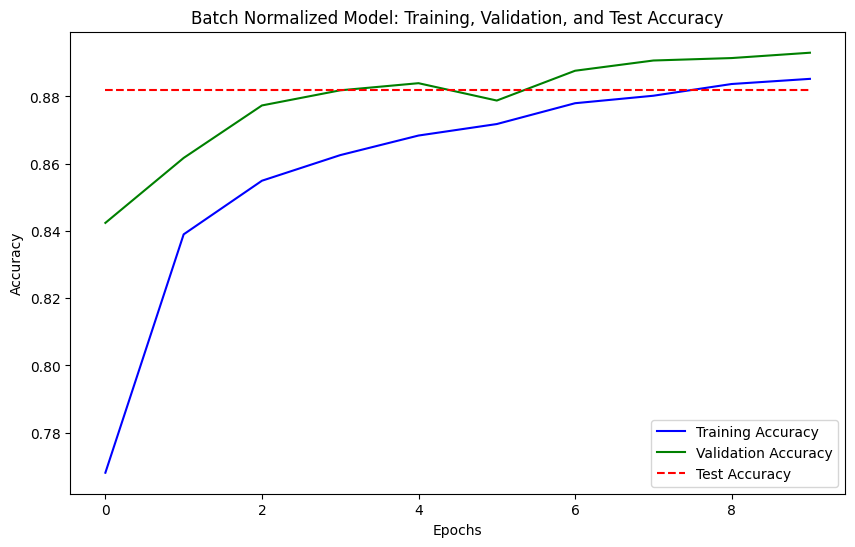

In [23]:
test_accuracy_repeated = [accuracy] * num_epochs

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), training_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(num_epochs), validation_accuracies, label='Validation Accuracy', color='green')
plt.plot(range(num_epochs), test_accuracy_repeated, label='Test Accuracy', color='red', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Batch Normalized Model: Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

<h3>Learning Rate Scheduler Method to optimize CNN</h3>

In [24]:
def train_modelLR(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    best_val_acc = 0.0
    training_losses = []
    validation_losses = []

    training_accuracies = []
    validation_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        scheduler.step()
        
        train_loss = train_loss / len(train_loader.dataset)
        training_losses.append(train_loss)
        train_acc = train_correct / train_total
        training_accuracies.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        validation_losses.append(val_loss)
        val_acc = val_correct / val_total
        validation_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
    
    model.load_state_dict(best_model_state)
    return model, best_val_acc, training_losses, training_accuracies, validation_losses, validation_accuracies

criterion = nn.CrossEntropyLoss()
num_epochs = 10
model = BaseCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

startTime = time.time()
LRModel, best_val_acc, training_losses, training_accuracies, validation_losses, validation_accuracies = train_modelLR(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs)
endTime = time.time()
trainingTime = endTime - startTime

LRModel.eval()
all_preds = []
all_labels = []
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = LRModel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

LRAccuracy = correct / total
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f"\nTraining completed in {trainingTime:.2f} seconds.")
print("------------------------------LEARNING RATE SCHEDULER OPTIMIZED MODEL------------------------------")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Final Metrics on Validation Set:")
print(f"Test Accuracy: {LRAccuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Epoch [1/10], Train Loss: 0.9635, Train Acc: 0.6896, Val Loss: 0.4667, Val Acc: 0.8335
Epoch [2/10], Train Loss: 0.5336, Train Acc: 0.8168, Val Loss: 0.4087, Val Acc: 0.8539
Epoch [3/10], Train Loss: 0.4686, Train Acc: 0.8378, Val Loss: 0.3683, Val Acc: 0.8685
Epoch [4/10], Train Loss: 0.4292, Train Acc: 0.8487, Val Loss: 0.3543, Val Acc: 0.8728
Epoch [5/10], Train Loss: 0.4058, Train Acc: 0.8566, Val Loss: 0.3626, Val Acc: 0.8696
Epoch [6/10], Train Loss: 0.3419, Train Acc: 0.8773, Val Loss: 0.3002, Val Acc: 0.8914
Epoch [7/10], Train Loss: 0.3208, Train Acc: 0.8836, Val Loss: 0.3018, Val Acc: 0.8894
Epoch [8/10], Train Loss: 0.3117, Train Acc: 0.8867, Val Loss: 0.2927, Val Acc: 0.8925
Epoch [9/10], Train Loss: 0.3076, Train Acc: 0.8869, Val Loss: 0.2909, Val Acc: 0.8941
Epoch [10/10], Train Loss: 0.3004, Train Acc: 0.8898, Val Loss: 0.2915, Val Acc: 0.8938

Training completed in 1051.56 seconds.
------------------------------LEARNING RATE SCHEDULER OPTIMIZED MODEL--------------------

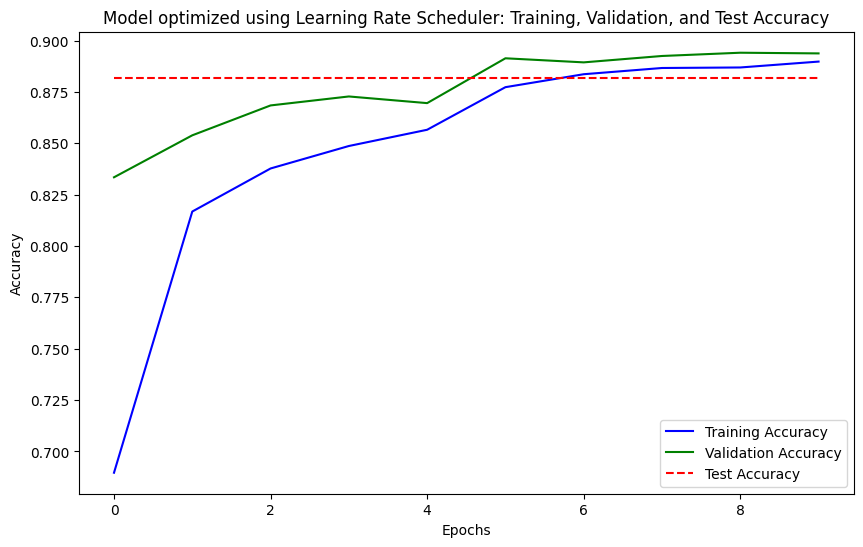

In [25]:
test_accuracy_repeated = [accuracy] * num_epochs

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), training_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(num_epochs), validation_accuracies, label='Validation Accuracy', color='green')
plt.plot(range(num_epochs), test_accuracy_repeated, label='Test Accuracy', color='red', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model optimized using Learning Rate Scheduler: Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

<h3>K-Fold Optimization Method to optimize CNN</h3>

In [26]:
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
model = BaseCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []

startTime = time.time()
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')

    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)

    train_loader = DataLoader(dataset, batch_size=32, sampler=train_subsampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_subsampler)

    model = BaseCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    KFoldModel, best_val_acc, training_losses, training_accuracies, validation_losses, validation_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

    fold_train_losses.append(training_losses)
    fold_val_losses.append(validation_losses)
    fold_train_accuracies.append(training_accuracies)
    fold_val_accuracies.append(validation_accuracies)

    print(f'Best validation accuracy for fold {fold+1}: {best_val_acc:.4f}')
    print('--------------------------------')
endTime = time.time()

trainingTime = endTime - startTime

avg_train_losses = np.mean(fold_train_losses, axis=0)
avg_val_losses = np.mean(fold_val_losses, axis=0)
avg_train_accuracies = np.mean(fold_train_accuracies, axis=0)
avg_val_accuracies = np.mean(fold_val_accuracies, axis=0)

KFoldAccuracy = avg_val_accuracies[-1]

print(f"\nTraining completed in {trainingTime:.2f} seconds.")
print("------------------------------K-FOLD OPTIMIZED MODEL------------------------------")
print(f'Average performance across all {k_folds} folds:')
print(f'Final Train Loss: {avg_train_losses[-1]:.4f}')
print(f'Final Validation Loss: {avg_val_losses[-1]:.4f}')
print(f'Final Train Accuracy: {avg_train_accuracies[-1]:.4f}')
print(f'Final Validation Accuracy: {KFoldAccuracy:.4f}')

FOLD 1
--------------------------------
Epoch [1/10], Train Loss: 0.6886, Train Acc: 0.7173, Val Loss: 0.0912, Val Acc: 0.8372
Epoch [2/10], Train Loss: 0.4092, Train Acc: 0.8237, Val Loss: 0.0791, Val Acc: 0.8625
Epoch [3/10], Train Loss: 0.3639, Train Acc: 0.8424, Val Loss: 0.0746, Val Acc: 0.8652
Epoch [4/10], Train Loss: 0.3423, Train Acc: 0.8511, Val Loss: 0.0721, Val Acc: 0.8696
Epoch [5/10], Train Loss: 0.3260, Train Acc: 0.8563, Val Loss: 0.0680, Val Acc: 0.8780
Epoch [6/10], Train Loss: 0.3107, Train Acc: 0.8610, Val Loss: 0.0668, Val Acc: 0.8776
Epoch [7/10], Train Loss: 0.3012, Train Acc: 0.8671, Val Loss: 0.0655, Val Acc: 0.8827
Epoch [8/10], Train Loss: 0.2932, Train Acc: 0.8687, Val Loss: 0.0654, Val Acc: 0.8801
Epoch [9/10], Train Loss: 0.2873, Train Acc: 0.8701, Val Loss: 0.0642, Val Acc: 0.8838
Epoch [10/10], Train Loss: 0.2854, Train Acc: 0.8722, Val Loss: 0.0641, Val Acc: 0.8834
Best validation accuracy for fold 1: 0.8838
--------------------------------
FOLD 2
-----

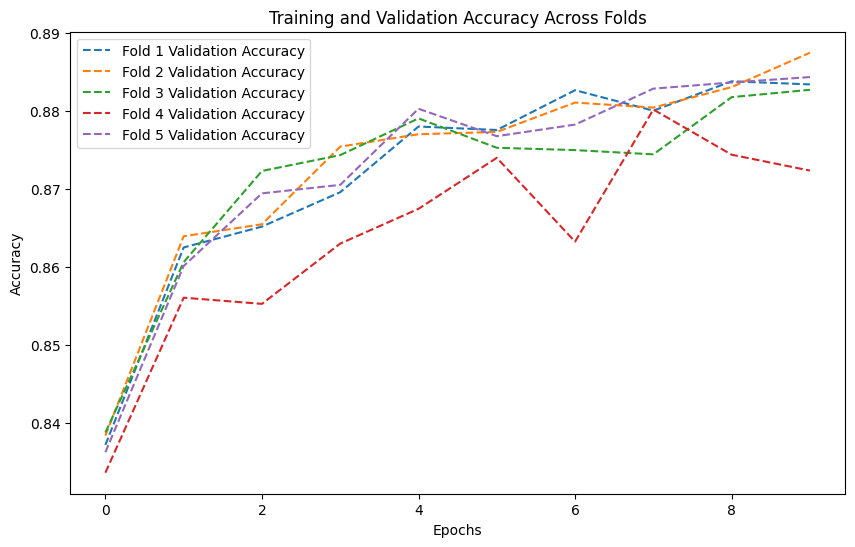

In [27]:
plt.figure(figsize=(10, 6))

for fold in range(k_folds):
    plt.plot(fold_val_accuracies[fold], label=f'Fold {fold+1} Validation Accuracy', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Across Folds')

plt.legend(loc='best')

plt.show()

In [28]:
print("------------------------------COMPARING ACCURACIES FOR EACH OPTIMIZATION METHOD------------------------------")
print(f"Batch Normalization Optimization Accuracy: {BNAccuracy}")
print(f"Learning Rate Scheduler Optimization Accuracy: {LRAccuracy}")
print(f"K-Fold Optimization Accuracy: {KFoldAccuracy}")

max_accuracy = max(BNAccuracy, LRAccuracy, KFoldAccuracy)

print(f"∴ We achieve the best model by {max({'Batch Normalization': BNAccuracy, 'Learning Rate Scheduler': LRAccuracy, 'K-Fold Optimization': KFoldAccuracy}, key=lambda k: {'Batch Normalization': BNAccuracy, 'Learning Rate Scheduler': LRAccuracy, 'K-Fold Optimization': KFoldAccuracy}[k])} technique with an accuracy of: {max(BNAccuracy, LRAccuracy, KFoldAccuracy):.4f}.")

------------------------------COMPARING ACCURACIES FOR EACH OPTIMIZATION METHOD------------------------------
Batch Normalization Optimization Accuracy: 0.8931878306878307
Learning Rate Scheduler Optimization Accuracy: 0.8928571428571429
K-Fold Optimization Accuracy: 0.8820833333333334
∴ We achieve the best model by Batch Normalization technique with an accuracy of: 0.8932.


<h2 style="
    font-family: 'Helvetica Neue', sans-serif;
    color: #2c3e50;
    background: linear-gradient(to right, #3498db, #8e44ad);
    -webkit-background-clip: text;
    color: transparent;
    font-weight: 700;
    letter-spacing: 1px;
    text-transform: uppercase;
    text-shadow: 2px 4px 6px rgba(0, 0, 0, 0.1);
    padding-bottom: 10px;
    border-bottom: 2px solid #3498db;
">Step 7: Evaluate the performance of the model on the testing data.</h2>
<h3>Setting up the base model as Batch Normalized Model Base Model</h3>

In [29]:
# Calculating final metrics on Batch Normalized base model
class BNModel(BaseCNN):
    def __init__(self):
        super(BNModel, self).__init__()
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm1d(512)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = BNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

startTime = time.time()
BatchNormModel, best_val_acc, training_losses, training_accuracies, validation_losses, validation_accuracies = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)
endTime = time.time()
trainingTime = endTime - startTime

BatchNormModel.eval()
all_preds = []
all_labels = []
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = BatchNormModel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

BNAccuracy = correct / total
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f"\nTraining completed in {trainingTime:.2f} seconds.")
print("------------------------------BATCH NORMALIZED MODEL------------------------------")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Final Metrics on Validation Set:")
print(f"Test Accuracy: {BNAccuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Epoch [1/10], Train Loss: 0.7297, Train Acc: 0.7661, Val Loss: 0.4356, Val Acc: 0.8478
Epoch [2/10], Train Loss: 0.4548, Train Acc: 0.8413, Val Loss: 0.3699, Val Acc: 0.8696
Epoch [3/10], Train Loss: 0.4112, Train Acc: 0.8528, Val Loss: 0.3336, Val Acc: 0.8783
Epoch [4/10], Train Loss: 0.3801, Train Acc: 0.8633, Val Loss: 0.3253, Val Acc: 0.8812
Epoch [5/10], Train Loss: 0.3620, Train Acc: 0.8691, Val Loss: 0.3129, Val Acc: 0.8800
Epoch [6/10], Train Loss: 0.3492, Train Acc: 0.8735, Val Loss: 0.3087, Val Acc: 0.8861
Epoch [7/10], Train Loss: 0.3418, Train Acc: 0.8748, Val Loss: 0.3003, Val Acc: 0.8870
Epoch [8/10], Train Loss: 0.3233, Train Acc: 0.8804, Val Loss: 0.2943, Val Acc: 0.8910
Epoch [9/10], Train Loss: 0.3161, Train Acc: 0.8835, Val Loss: 0.2938, Val Acc: 0.8923
Epoch [10/10], Train Loss: 0.3091, Train Acc: 0.8838, Val Loss: 0.2885, Val Acc: 0.8923

Training completed in 1130.43 seconds.
------------------------------BATCH NORMALIZED MODEL------------------------------
Best V

<h2 style="
    font-family: 'Helvetica Neue', sans-serif;
    color: #2c3e50;
    background: linear-gradient(to right, #3498db, #8e44ad);
    -webkit-background-clip: text;
    color: transparent;
    font-weight: 700;
    letter-spacing: 1px;
    text-transform: uppercase;
    text-shadow: 2px 4px 6px rgba(0, 0, 0, 0.1);
    padding-bottom: 10px;
    border-bottom: 2px solid #3498db;
">Step 8: Save the weights of the trained neural network that returns the best results.</h2>

In [30]:
torch.save(BatchNormModel.state_dict(), 'jagritsh_pgnanase_assignment2_part3.pt')

<h2 style="
    font-family: 'Helvetica Neue', sans-serif;
    color: #2c3e50;
    background: linear-gradient(to right, #3498db, #8e44ad);
    -webkit-background-clip: text;
    color: transparent;
    font-weight: 700;
    letter-spacing: 1px;
    text-transform: uppercase;
    text-shadow: 2px 4px 6px rgba(0, 0, 0, 0.1);
    padding-bottom: 10px;
    border-bottom: 2px solid #3498db;
">Step 9: Visualize the results. Include the following graphs:</h2>

<h3>1. A graph that compares training, validation and test accuracy on the same plot with clear labeling.</h3>

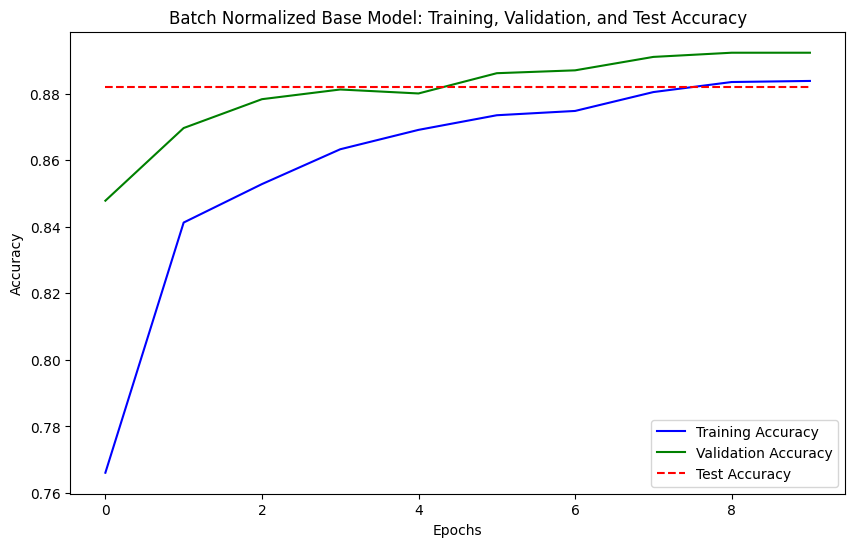

In [31]:
test_accuracy_repeated = [accuracy] * num_epochs

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), training_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(num_epochs), validation_accuracies, label='Validation Accuracy', color='green')
plt.plot(range(num_epochs), test_accuracy_repeated, label='Test Accuracy', color='red', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Batch Normalized Base Model: Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

<h3>2. A graph that compares training, validation and test loss on the same plot with a clear labeling.</h3>

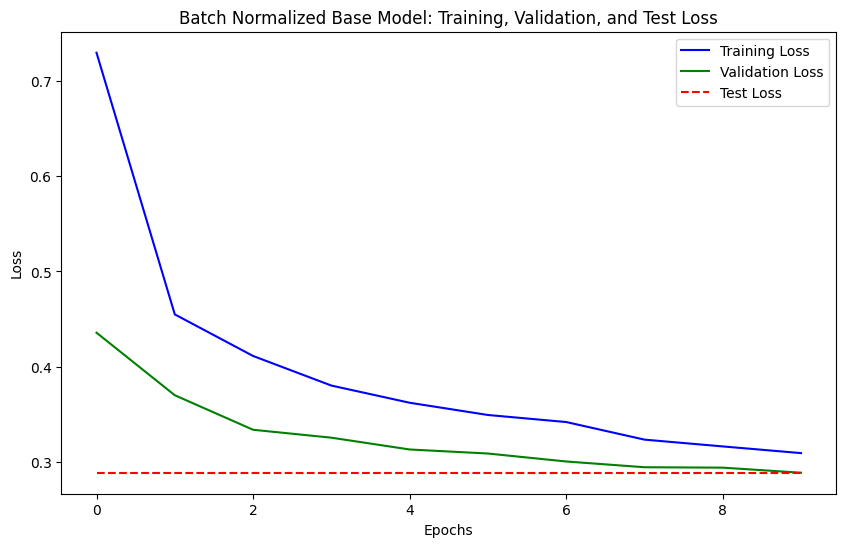

In [32]:
test_loss = validation_losses[-1]
test_loss_repeated = [test_loss] * num_epochs

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), training_losses, label='Training Loss', color='blue')
plt.plot(range(num_epochs), validation_losses, label='Validation Loss', color='green')
plt.plot(range(num_epochs), test_loss_repeated, label='Test Loss', color='red', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Batch Normalized Base Model: Training, Validation, and Test Loss')
plt.legend()
plt.show()

<h3>3. Confusion matrix on the test data</h3>

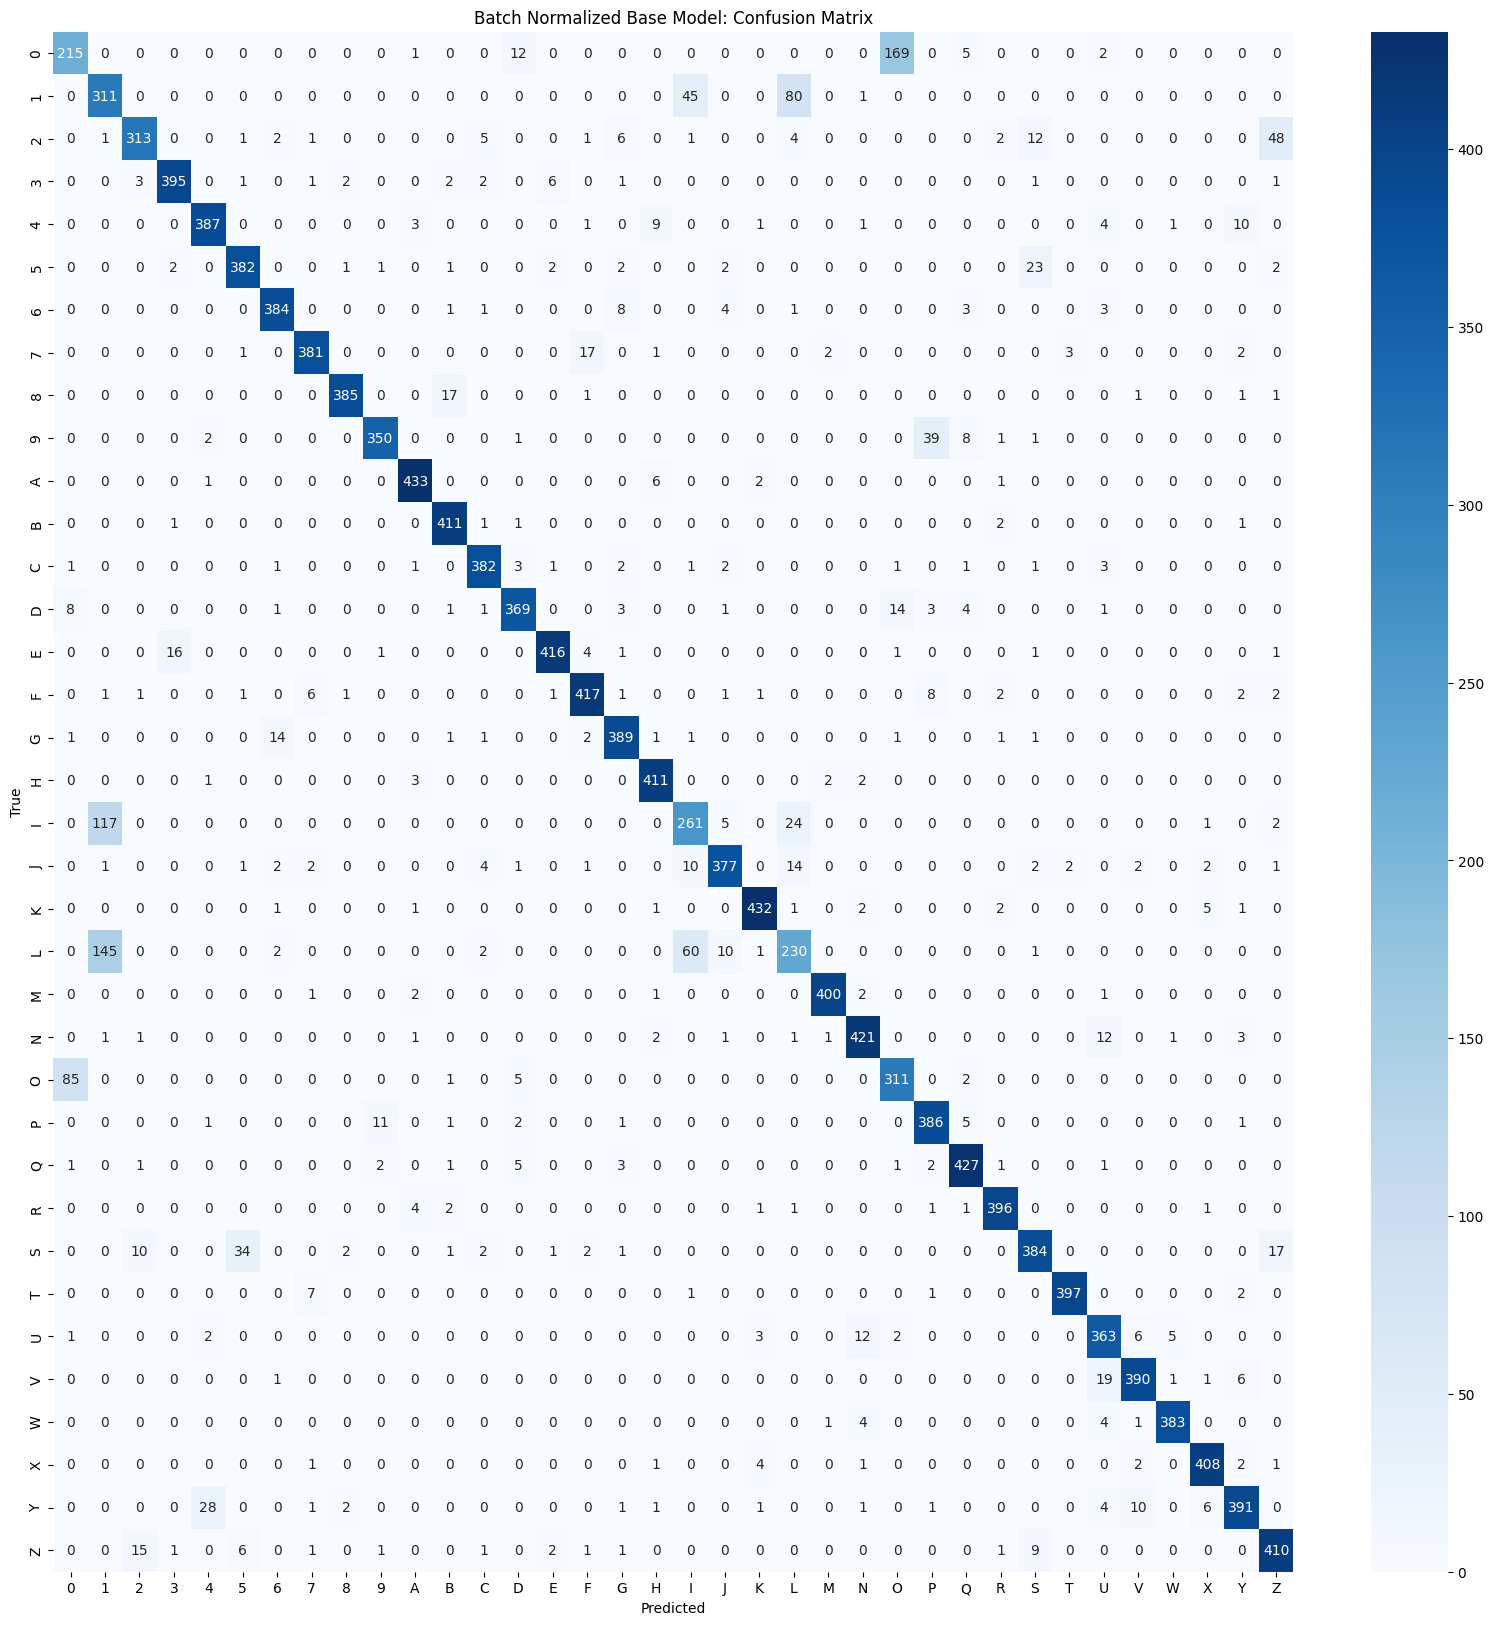

In [33]:
conf_matrix = confusion_matrix(all_labels, all_preds)

class_names = dataset.classes

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Batch Normalized Base Model: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<h3>4. ROC curve (receiver operating characteristic curve).</h3>

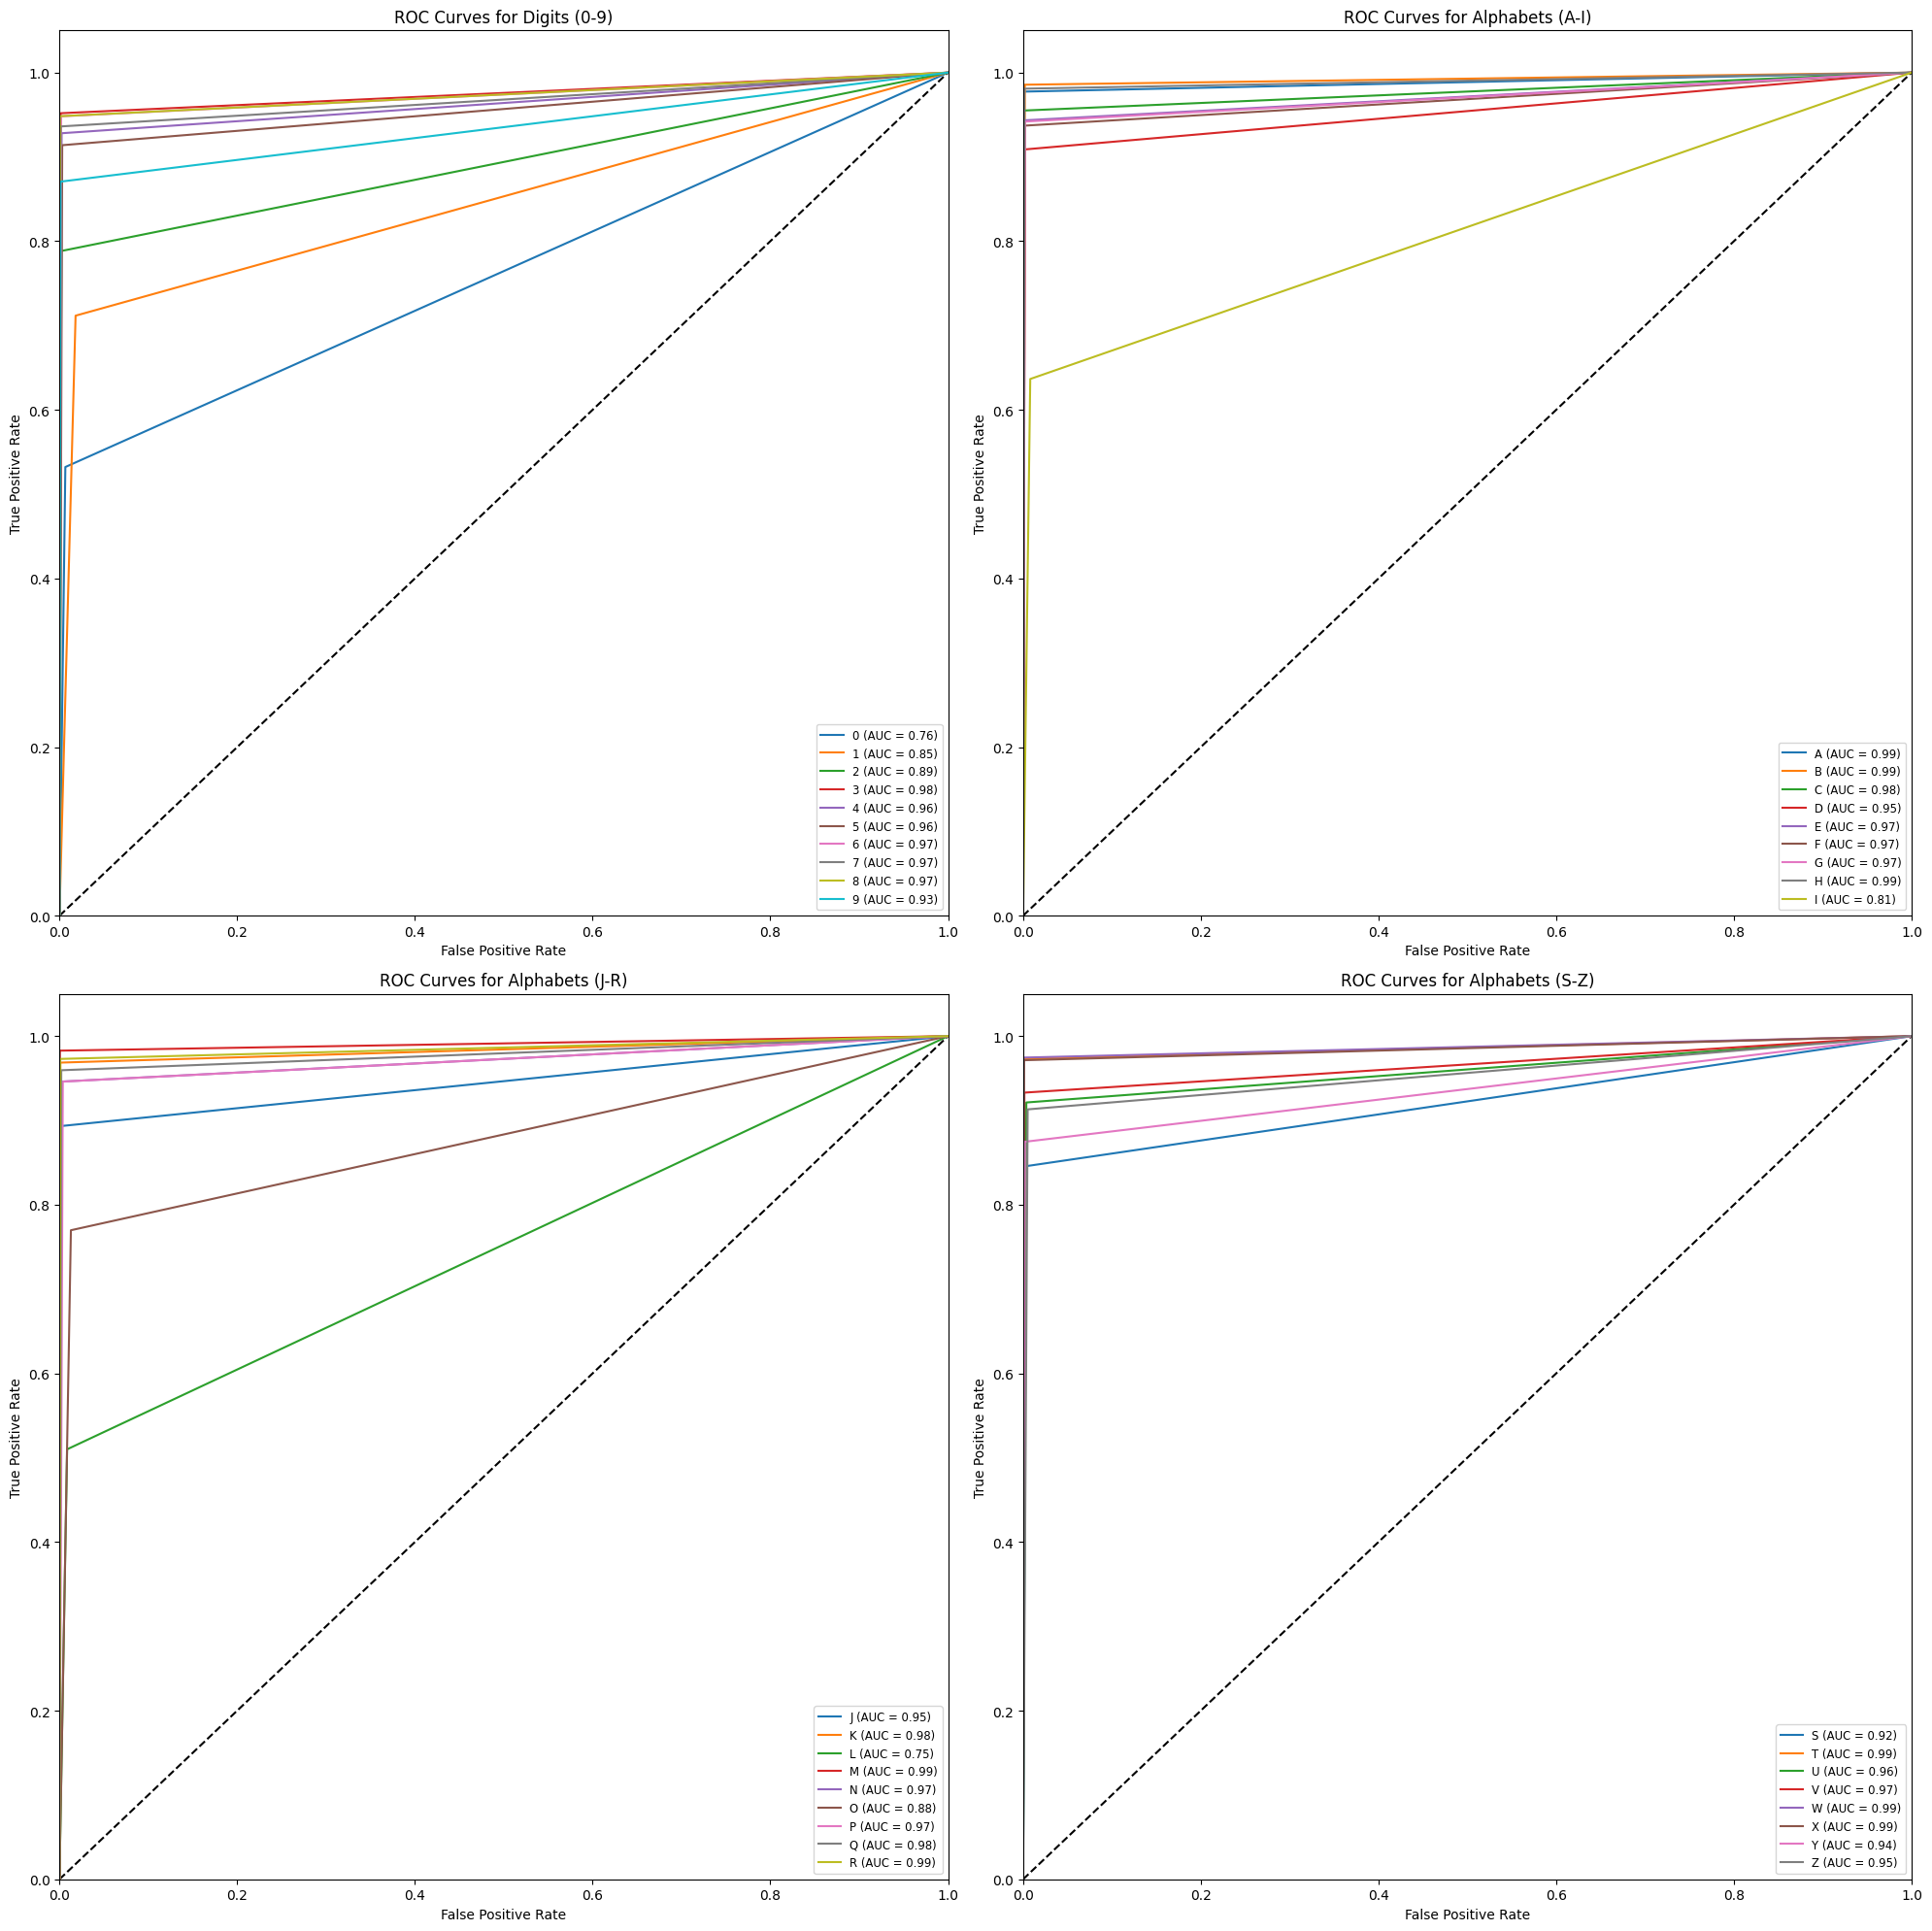

Average AUC: 0.9450


In [34]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

classes = np.unique(np.concatenate((all_labels, all_preds)))
n_classes = len(classes)

all_labels_bin = label_binarize(all_labels, classes=classes)
all_preds_bin = label_binarize(all_preds, classes=classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_preds_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs = axs.ravel()

axs[0].plot([0, 1], [0, 1], 'k--')
for i in range(10):
    axs[0].plot(fpr[i], tpr[i], label=f'{i} (AUC = {roc_auc[i]:.2f})')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curves for Digits (0-9)')
axs[0].legend(loc="lower right", fontsize='small')

for j in range(1, 4):
    axs[j].plot([0, 1], [0, 1], 'k--')
    for k in range(9):
        idx = 10 + (j-1)*9 + k
        if idx < n_classes:
            axs[j].plot(fpr[idx], tpr[idx], label=f'{chr(65+idx-10)} (AUC = {roc_auc[idx]:.2f})')
    axs[j].set_xlim([0.0, 1.0])
    axs[j].set_ylim([0.0, 1.05])
    axs[j].set_xlabel('False Positive Rate')
    axs[j].set_ylabel('True Positive Rate')
    axs[j].set_title(f'ROC Curves for Alphabets ({chr(65+(j-1)*9)}-{chr(min(65+(j-1)*9+8, 90))})')
    axs[j].legend(loc="lower right", fontsize='small')

plt.tight_layout()
plt.show()

print(f"Average AUC: {np.mean(list(roc_auc.values())):.4f}")

<h2>References:</h2>
<ul>
    <li>Assignment 1</li>
    <li><a href="https://pytorch.org/docs/stable/tensors.html">https://pytorch.org/docs/stable/tensors.html</a></li>
    <li><a href="https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html">https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html</a></li>
    <li><a href="https://pytorch.org/docs/stable/nn.html">https://pytorch.org/docs/stable/nn.html</a></li>
    <li><a href="https://github.com/TylerYep/torchinfo">https://github.com/TylerYep/torchinfo</a></li>
    <li><a href="https://docs.python.org/3/library/time.html">https://docs.python.org/3/library/time.html</a></li>
    <li><a href="https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html">https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html</a></li>
    <li><a href="https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc">https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc</a></li>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html">https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html</a></li>
    <li><a href="https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau">https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau</a></li>
    <li><a href="https://geeksforgeeks.org/batch-normalization-implementation-in-pytorch/">https://geeksforgeeks.org/batch-normalization-implementation-in-pytorch/</a></li>
    <li><a href="https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07">https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07</a></li>
    <li><a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">https://pytorch.org/tutorials/beginner/basics/data_tutorial.html</a></li>
    <li><a href="https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html">https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html</a></li>
</ul>